In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

from subprocess import check_output
#print(check_output(["ls", "../DataFiles"]).decode("utf8"))

In [2]:
data_dir = '../input/'

In [3]:
seeds = pd.read_csv('./DataFiles/NCAATourneySeeds.csv')
tourney = pd.read_csv('./DataFiles/NCAATourneyCompactResults.csv')

### Will be creating a simple log loss submission off of seeds and their differentials.

In [47]:
def seed_to_int(seed):
    s_int = int(seed[1:3])
    return s_int

seeds['Seed_Int'] = seeds['Seed'].apply(seed_to_int)

In [48]:
seeds.head()

,Season,Seed,TeamID,Seed_Int
0,1985,W01,1207,1
1,1985,W02,1210,2
2,1985,W03,1228,3
3,1985,W04,1260,4
4,1985,W05,1374,5


In [49]:
seeds.drop(labels=['Seed'], inplace=True, axis=1)
seeds.head()

,Season,TeamID,Seed_Int
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5


In [50]:
tourney.drop(labels=['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], inplace=True, axis=1)

In [51]:
tourney.head()

,Season,WTeamID,LTeamID
0,1985,1116,1234
1,1985,1120,1345
2,1985,1207,1250
3,1985,1229,1425
4,1985,1242,1325


### Merge seed for each team to the df.

In [52]:
winners = seeds.rename(columns={'TeamID': 'WTeamID', 'Seed_Int': 'WSeed'})
losers = seeds.rename(columns={'TeamID': 'LTeamID', 'Seed_Int': 'LSeed'})
dummy = pd.merge(left=tourney, right=winners, how='left', on=['Season', 'WTeamID'])
new = pd.merge(left=dummy, right=losers, on=['Season', 'LTeamID'])
new["SeedDifferential"] = new.WSeed - new.LSeed
new.head()

,Season,WTeamID,LTeamID,WSeed,LSeed,SeedDifferential
0,1985,1116,1234,9,8,1
1,1985,1120,1345,11,6,5
2,1985,1207,1250,1,16,-15
3,1985,1229,1425,9,8,1
4,1985,1242,1325,3,14,-11


### Creating a summary df


In [53]:
wins = pd.DataFrame()
wins['SeedDifferential'] = new['SeedDifferential']
wins["Result"] = 1

losses = pd.DataFrame()
losses['SeedDifferential'] = -new['SeedDifferential']
losses['Result'] = 0

predictions = pd.concat((wins, losses))
predictions.head()

,SeedDifferential,Result
0,1,1
1,5,1
2,-15,1
3,1,1
4,-11,1


In [54]:
X_train = predictions.SeedDifferential.values.reshape(-1,1)
y_train = predictions.Result.values
X_train, y_train = shuffle(X_train, y_train)


### Train and Gridsearch the model.

In [55]:
log = LogisticRegression()
params = {
    
    'C': np.logspace(start=-1, stop=1, num=150),
    'penalty': ['l1', 'l2'],
    'random_state': [None, 42]
    
    
}
gs = GridSearchCV(log, param_grid=params, scoring='neg_log_loss', refit=True)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

-0.5531046178688698
{'C': 0.1, 'penalty': 'l1', 'random_state': None}


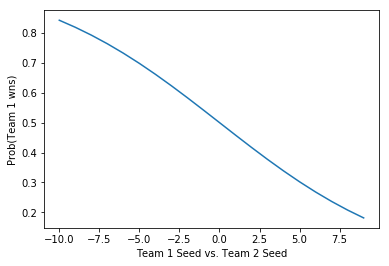

In [56]:
X = np.arange(-10,10).reshape(-1,1)
preds = gs.predict_proba(X)[:,1]

plt.plot(X,preds)
plt.xlabel("Team 1 Seed vs. Team 2 Seed")
plt.ylabel("Prob(Team 1 wns)")

In [59]:
submission = pd.read_csv('SampleSubmissionStage1.csv')
len_test_games = len(submission)

def get_year_t1_t2(ID):
    return (int(x) for x in ID.split('_'))

X_test = np.zeros(shape=(len_test_games, 1))
for ii, row in submission.iterrows():
    year, t1, t2 = get_year_t1_t2(row.ID)
    t1_seed = seeds[(seeds.TeamID == t1) & (seeds.Season == year)].Seed_Int.values[0]
    t2_seed = seeds[(seeds.TeamID == t2) & (seeds.Season == year)].Seed_Int.values[0]
    seed_diff = t1_seed - t2_seed
    X_test[ii, 0] = seed_diff

preds = gs.predict_proba(X_test)[:,1]

short_preds = np.clip(preds, .05, .95)
submission.Pred = short_preds
submission.head()

In [63]:
submission.to_csv("log_loss_1.csv", index=False)